In [10]:
%store -r full_path
import math
import numpy as np
import matplotlib.pyplot as plt

class RobotState:
    def __init__(self, x=0.0, y=0.0, theta=0.0):
        self.x = x
        self.y = y
        self.theta = theta 

    def update(self, v_left_mps, v_right_mps, dt, wheelbase):
        v_robot = (v_left_mps + v_right_mps) / 2.0
        omega = (v_right_mps - v_left_mps) / wheelbase 

        self.x += v_robot * math.cos(self.theta) * dt
        self.y += v_robot * math.sin(self.theta) * dt
        self.theta += omega * dt
        
        self.theta = math.atan2(math.sin(self.theta), math.cos(self.theta))

    def __repr__(self):
        return f"RobotState(x={self.x:.2f}, y={self.y:.2f}, theta={math.degrees(self.theta):.1f}°)"


In [36]:
%store -r full_path
import math
import numpy as np
import matplotlib.pyplot as plt

class RobotState:
    def __init__(self, x=0.0, y=0.0, theta=0.0):
        self.x = x
        self.y = y
        self.theta = theta 

    def update(self, v_left_mps, v_right_mps, dt, wheelbase):
        v_robot = (v_left_mps + v_right_mps) / 2.0
        omega = (v_right_mps - v_left_mps) / wheelbase 

        self.x += v_robot * math.cos(self.theta) * dt
        self.y += v_robot * math.sin(self.theta) * dt
        self.theta += omega * dt
        
        self.theta = math.atan2(math.sin(self.theta), math.cos(self.theta))

    def __repr__(self):
        return f"RobotState(x={self.x:.2f}, y={self.y:.2f}, theta={math.degrees(self.theta):.1f}°)"

class PurePursuitController:
    def __init__(self, path_xy, lookahead_distance, wheelbase, max_speed, target_speed, target_reached_threshold=0.05): 
        self.path_xy = np.array(path_xy)
        self.Ld = lookahead_distance
        self.wheelbase = wheelbase
        self.max_speed = max_speed
        self.target_speed = target_speed
        self.current_segment_idx = 0
        self.TARGET_REACHED_THRESHOLD = target_reached_threshold

    def _find_lookahead_point(self, robot_pos_xy):
        robot_x, robot_y = robot_pos_xy
        final_wp = self.path_xy[-1]
        num_points = len(self.path_xy)
        idx_last_segment = num_points - 2 

        dist_to_final_wp_sq = (robot_x - final_wp[0])**2 + (robot_y - final_wp[1])**2

        is_on_late_segment = self.current_segment_idx >= (num_points - 2) * 0.75
        
        if (is_on_late_segment and dist_to_final_wp_sq < (self.Ld * 1.5)**2) or \
           (dist_to_final_wp_sq < (self.TARGET_REACHED_THRESHOLD * 1.5)**2) :
             return final_wp, idx_last_segment 

        found_lookahead_point = None 
        for i in range(self.current_segment_idx, num_points - 1):
            p1 = self.path_xy[i]
            p2 = self.path_xy[i+1]
            
            d_segment_vec = p2 - p1  
            f_robot_to_p1_vec = p1 - robot_pos_xy 
            
            a_quad = np.dot(d_segment_vec, d_segment_vec)
            if a_quad < 1e-9: continue 

            b_quad = 2 * np.dot(f_robot_to_p1_vec, d_segment_vec)
            c_quad = np.dot(f_robot_to_p1_vec, f_robot_to_p1_vec) - self.Ld**2
            
            discriminant = b_quad**2 - 4 * a_quad * c_quad
            
            if discriminant >= 0:
                sqrt_discriminant = math.sqrt(discriminant)
                u1 = (-b_quad - sqrt_discriminant) / (2 * a_quad)
                u2 = (-b_quad + sqrt_discriminant) / (2 * a_quad)
                
                valid_us_on_segment = []
                if 0 <= u1 <= 1: valid_us_on_segment.append(u1)
                if 0 <= u2 <= 1: valid_us_on_segment.append(u2)

                if valid_us_on_segment:
                    best_u = max(valid_us_on_segment) 
                    found_lookahead_point = p1 + best_u * d_segment_vec
                    return found_lookahead_point, i 

        if self.current_segment_idx < idx_last_segment:
            return self.path_xy[self.current_segment_idx + 1], self.current_segment_idx
        else: 
            return final_wp, idx_last_segment


    def calculate_steering_curvature(self, robot_state, lookahead_point_xy):
        if lookahead_point_xy is None:
            return 0.0 

        robot_x, robot_y, robot_theta = robot_state.x, robot_state.y, robot_state.theta
        target_x, target_y = lookahead_point_xy

        x_local = (target_x - robot_x) * math.cos(robot_theta) + \
                  (target_y - robot_y) * math.sin(robot_theta)
        y_local = -(target_x - robot_x) * math.sin(robot_theta) + \
                   (target_y - robot_y) * math.cos(robot_theta)
            
        actual_dist_sq = x_local**2 + y_local**2
        if actual_dist_sq < 0.0001: 
            return 0.0
        
        if x_local < 0.01 : 
            max_reasonable_curvature = 2.0 / self.wheelbase 
            return np.sign(y_local) * max_reasonable_curvature 
            
        curvature = (2 * y_local) / actual_dist_sq
        return curvature

    def get_wheel_velocities(self, robot_state):
        lookahead_point, found_on_segment_idx = self._find_lookahead_point((robot_state.x, robot_state.y))
        
        if found_on_segment_idx > self.current_segment_idx:
             self.current_segment_idx = found_on_segment_idx
        else: 
            if self.current_segment_idx < len(self.path_xy) - 2: 
                current_segment_end_point = self.path_xy[self.current_segment_idx + 1]
                dist_to_current_segment_end_sq = (robot_state.x - current_segment_end_point[0])**2 + \
                                                 (robot_state.y - current_segment_end_point[1])**2
                if dist_to_current_segment_end_sq < (self.Ld * 0.75)**2: 
                     self.current_segment_idx += 1
        
        self.current_segment_idx = min(self.current_segment_idx, len(self.path_xy) - 2)
        
        if lookahead_point is None: 
            return 0.0, 0.0, None 

        curvature = self.calculate_steering_curvature(robot_state, lookahead_point)
        current_target_speed = self.target_speed

        turn_factor = abs(curvature * self.wheelbase)

        is_final_target_point = (lookahead_point[0] == self.path_xy[-1][0] and \
                                 lookahead_point[1] == self.path_xy[-1][1])
        dist_to_lookahead_sq = (robot_state.x - lookahead_point[0])**2 + \
                               (robot_state.y - lookahead_point[1])**2

        if is_final_target_point and dist_to_lookahead_sq < (self.TARGET_REACHED_THRESHOLD * 1.5)**2: 
            current_target_speed *= 0.1 
        elif is_final_target_point and dist_to_lookahead_sq < (self.Ld * 1.5)**2 : 
            current_target_speed *= 0.4 
        elif turn_factor > 1.75: 
            current_target_speed *= 0.15 
        elif turn_factor > 1.2: 
            current_target_speed *= 0.3 
        elif turn_factor > 0.8: 
            current_target_speed *= 0.5
        elif turn_factor > 0.5: 
            current_target_speed *= 0.7
        elif turn_factor > 0.2:
            current_target_speed *= 0.9
        
        min_operational_speed = self.max_speed * 0.05 
        if not (is_final_target_point and dist_to_lookahead_sq < (self.TARGET_REACHED_THRESHOLD * 1.5)**2):
             current_target_speed = max(current_target_speed, min_operational_speed) 

        v_left = current_target_speed * (1 - (curvature * self.wheelbase) / 2)
        v_right = current_target_speed * (1 + (curvature * self.wheelbase) / 2)

        v_left = np.clip(v_left, -self.max_speed, self.max_speed)
        v_right = np.clip(v_right, -self.max_speed, self.max_speed)
        
        return v_left, v_right, lookahead_point

        

Reached final target at t=41.20s.
Robot final state: RobotState(x=0.80, y=0.59, theta=89.1°)
Robot path length: 825


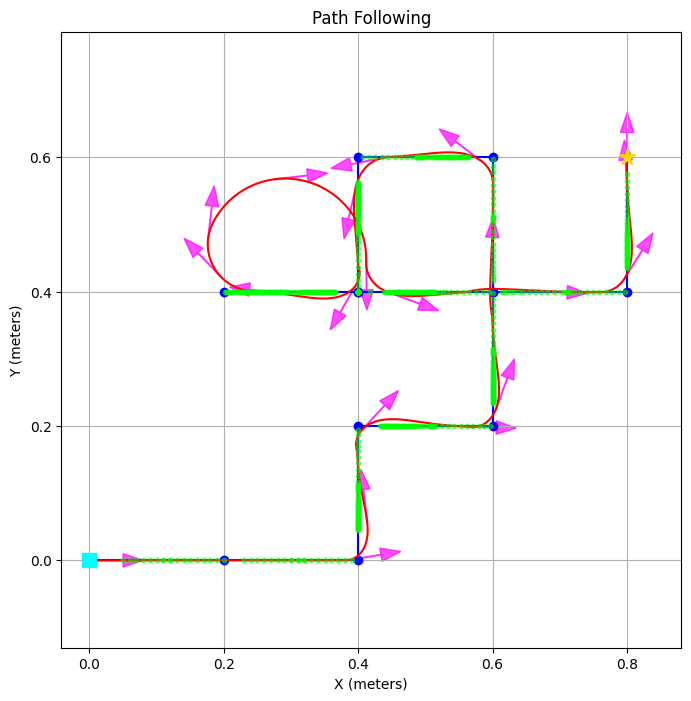

In [38]:
GRID_CELL_SIZE_METERS = 0.1

WHEELBASE_METERS = 0.14
MAX_SPEED_MPS = 0.20
LOOKAHEAD_DISTANCE = 0.05
TARGET_SPEED_MPS = 0.20

DT = .05
SIMULATION_DURATION_S = 60 
TARGET_REACHED_THRESHOLD = 0.01

path_xy_meters = np.array([(p[1] * GRID_CELL_SIZE_METERS, p[0] * GRID_CELL_SIZE_METERS) for p in full_path])

initial_x, initial_y = path_xy_meters[0]
if len(path_xy_meters) > 1:
    next_x, next_y = path_xy_meters[1]
    initial_theta = math.atan2(next_y - initial_y, next_x - initial_x)
else:
    initial_theta = 0.0 

robot = RobotState(x=initial_x, y=initial_y, theta=initial_theta)
controller = PurePursuitController(path_xy_meters, LOOKAHEAD_DISTANCE, WHEELBASE_METERS, MAX_SPEED_MPS, TARGET_SPEED_MPS)

robot_path_history = [] 
lookahead_history = []  

time_elapsed = 0.0
final_target_xy = path_xy_meters[-1]

controller.current_segment_idx = 0 

for i in range(int(SIMULATION_DURATION_S / DT)):
    robot_path_history.append((robot.x, robot.y, robot.theta))
    
    dist_to_final_target = math.sqrt((robot.x - final_target_xy[0])**2 + (robot.y - final_target_xy[1])**2)
    if dist_to_final_target < TARGET_REACHED_THRESHOLD and controller.current_segment_idx >= len(path_xy_meters) - 2 : 
        print(f"Reached final target at t={time_elapsed:.2f}s.")
        break

    v_left, v_right, current_lookahead_point = controller.get_wheel_velocities(robot)
    lookahead_history.append(current_lookahead_point)
    
    if current_lookahead_point is None:
        print(f"Warning: No lookahead point found at t={time_elapsed:.2f}s. Stopping robot.")
        v_left, v_right = 0.0, 0.0 

    robot.update(v_left, v_right, DT, WHEELBASE_METERS)
    time_elapsed += DT

else: 
    print(f"Simulation ended after {SIMULATION_DURATION_S:.2f}s. Final target might not have been reached.")

robot_path_history_np = np.array(robot_path_history)
lookahead_history_np = np.array([p if p is not None else (np.nan, np.nan) for p in lookahead_history])

print(f"Robot final state: {robot}")
print(f"Robot path length: {len(robot_path_history_np)}")
plt.figure(figsize=(8, 8))

plt.plot(path_xy_meters[:, 0], path_xy_meters[:, 1], 'bo-', label="Target Path (Waypoints)")

if robot_path_history_np.shape[0] > 0:
    plt.plot(robot_path_history_np[:, 0], robot_path_history_np[:, 1], 'r-', label="Robot's Path")
    for i in range(0, len(robot_path_history_np), max(1, len(robot_path_history_np)//20)): 
        x, y, theta = robot_path_history_np[i]
        plt.arrow(x, y, 0.05 * math.cos(theta), 0.05 * math.sin(theta),
                  head_width=0.02, head_length=0.03, fc='magenta', ec='magenta', alpha=0.7)

if lookahead_history_np.shape[0] > 0:
    plt.scatter(lookahead_history_np[:, 0], lookahead_history_np[:, 1], 
                c='lime', s=10, label="Lookahead Points", alpha=0.5, zorder=3)

plt.scatter(initial_x, initial_y, c='cyan', marker='s', s=100, label="Start", zorder=5)
plt.scatter(final_target_xy[0], final_target_xy[1], c='gold', marker='*', s=150, label="End Goal", zorder=5)

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Path Following")
plt.grid(True)
plt.axis('equal') 
plt.show()